In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import torch
import torch.utils.data
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

from sklearn.linear_model import SGDClassifier

from tqdm.auto import tqdm

from pynsm import SimilarityMatching

## Load dataset and create data loaders

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
dataset_name = "MNIST"
# dataset_name = 'CIFAR10'

if dataset_name == "MNIST":
    train_data = datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )
    test_data = datasets.MNIST(
        root="data", train=False, download=True, transform=transform
    )
    classes = [str(i) for i in range(10)]
if dataset_name == "CIFAR10":
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    train_data = datasets.CIFAR10(
        root="data", train=True, download=True, transform=transform
    )
    test_data = datasets.CIFAR10(
        root="data", train=False, download=True, transform=transform
    )
    classes = [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]

In [3]:
# Create training and test dataloaders
# number of subprocesses to use for data loading
# TT: num_workers > 0 can be problematic in notebooks
num_workers = 0
# how many samples per batch to load
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

batch min=0, mean=0.136, max=1


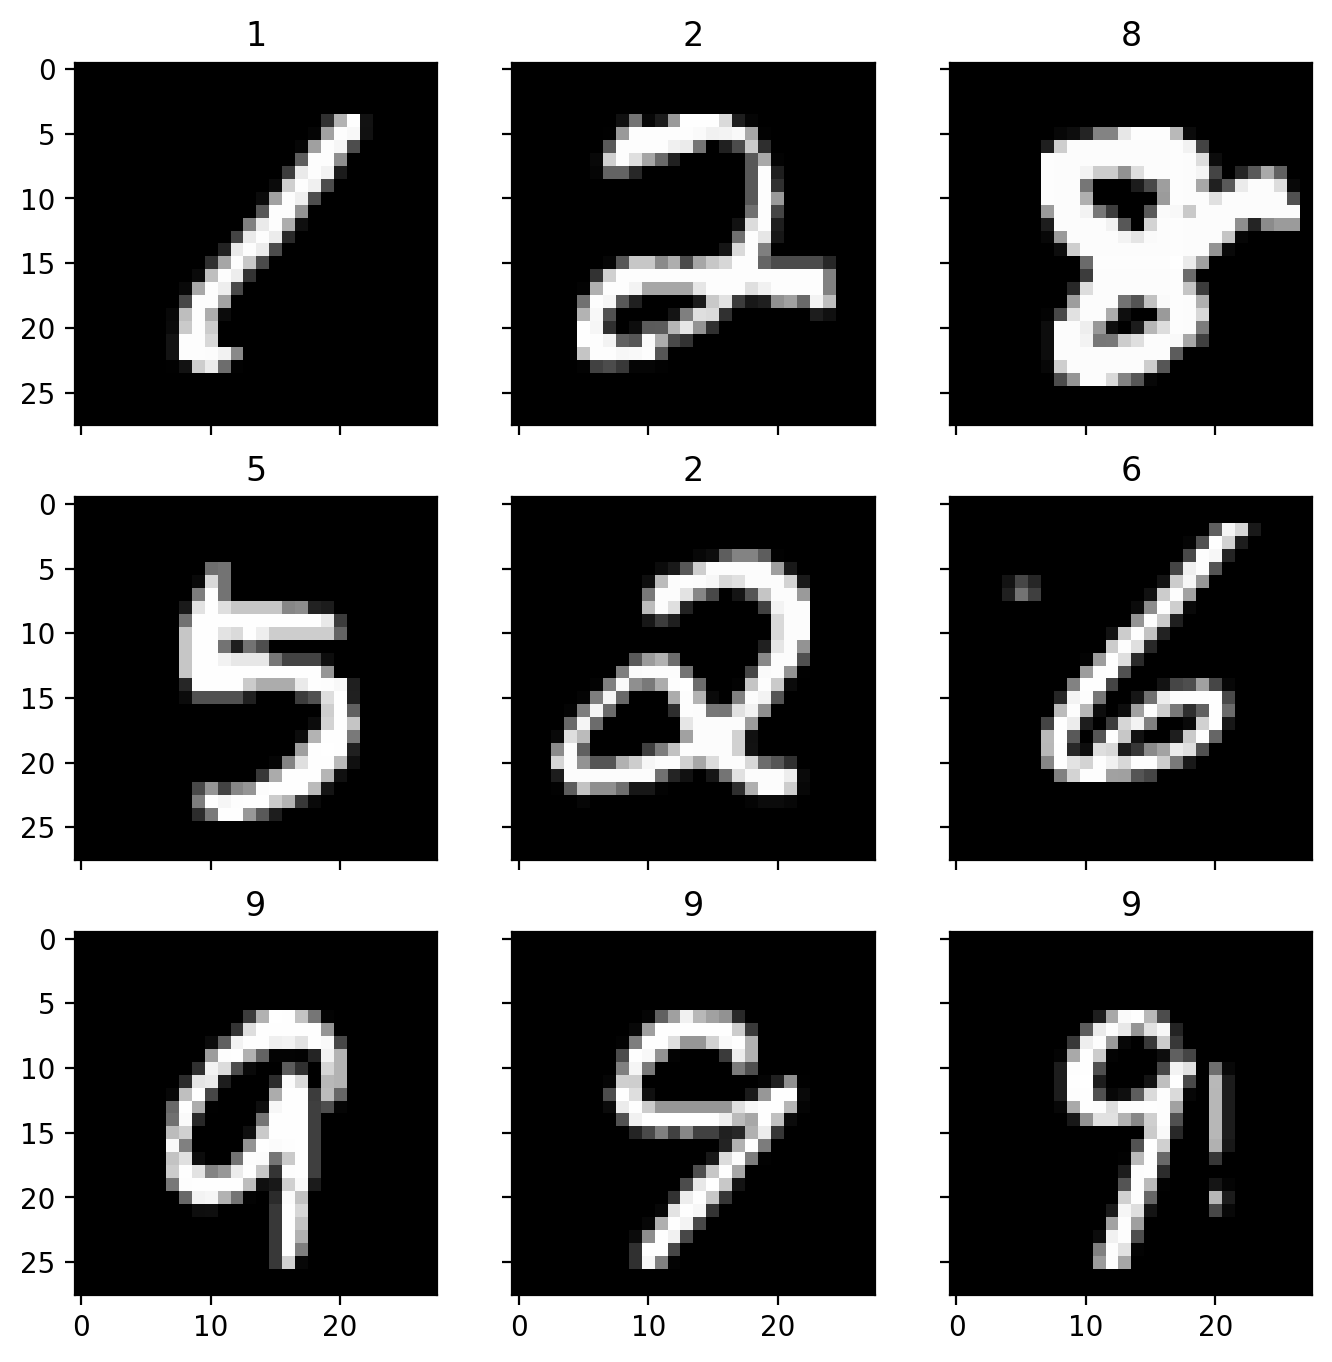

In [4]:
# show sample images
torch.manual_seed(42)

X_batch, y_batch = next(iter(train_loader))
X_max = X_batch.max()
X_min = X_batch.min()

print(f"batch min={X_min:.3g}, mean={X_batch.mean():.3g}, max={X_max:.3g}")

# create a grid of 3x3 images
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        batch_idx = i * 3 + j
        crt_X = X_batch[batch_idx]
        ax[i][j].imshow(crt_X.numpy().squeeze(), vmin=X_min, vmax=X_max, cmap="gray")
        ax[i][j].set_title(classes[y_batch[batch_idx].item()])

## Try the convolutional NSM module

In [35]:
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

n_epochs = 3
# n_epochs = 1
encoder = nn.Conv2d(1, 50, 6, stride=1, padding=0, bias=False)
model = SimilarityMatching(
    encoder, out_channels=50, iteration_projection=nn.ReLU(), iteration_lr=1e4
).to(device)

optimizer = torch.optim.Adam(model.parameters())

# iteration_loss_curves = []
# model.register_iteration_hook(
#     "iteration", lambda m: iteration_loss_curves.append(m.last_iteration_loss)
# )

running_loss = []
for epoch in range(n_epochs):
    pbar = tqdm(train_loader, desc=f"epoch {epoch + 1} / {n_epochs}")
    sample = 0
    for idx, data in enumerate(pbar):
        images, _ = data

        images = images.to(device)

        outputs = model(images)
        loss = model.loss(images, outputs) + (encoder.weight**2).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # pooled_outputs = model.pool_output(outputs, k_size=2, stri=2)
        # loss = model.loss_NSM_conv(outputs, images)
        running_loss.append(loss.item())

        pbar.set_postfix({"sample": sample, "loss": running_loss[-1]}, refresh=False)

        sample += len(images)

Running on cpu.


epoch 1 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 2 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 3 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

Text(0, 0.5, 'loss')

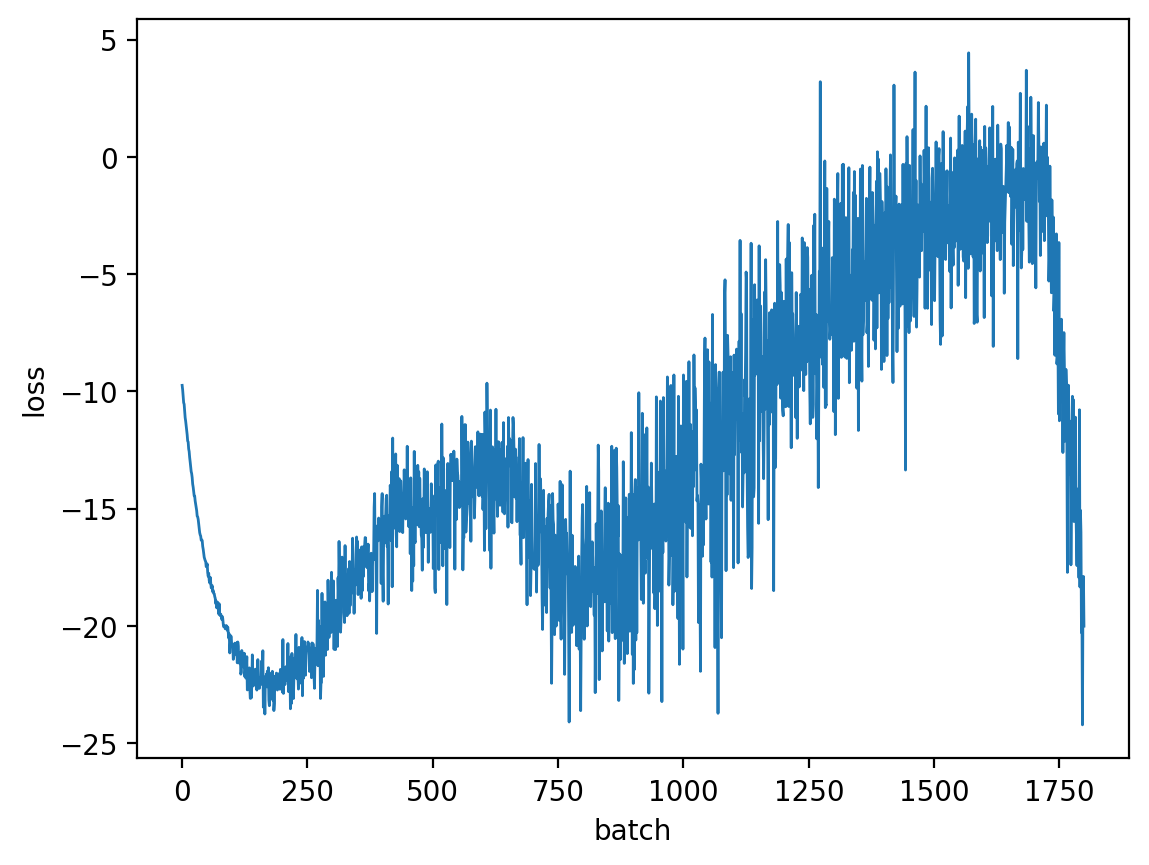

In [36]:
fig, ax = plt.subplots()
ax.plot(running_loss, lw=1.0)
ax.set_xlabel("batch")
ax.set_ylabel("loss")

In [37]:
[(a, b.shape) for a, b in list(model.named_parameters())]

[('encoder.weight', torch.Size([50, 1, 6, 6])),
 ('competitor.weight', torch.Size([50, 50]))]

In [38]:
(model.encoder.weight.abs().max(), model.competitor.weight.abs().max())

(tensor(1.2425, grad_fn=<MaxBackward1>),
 tensor(3.2986, grad_fn=<MaxBackward1>))

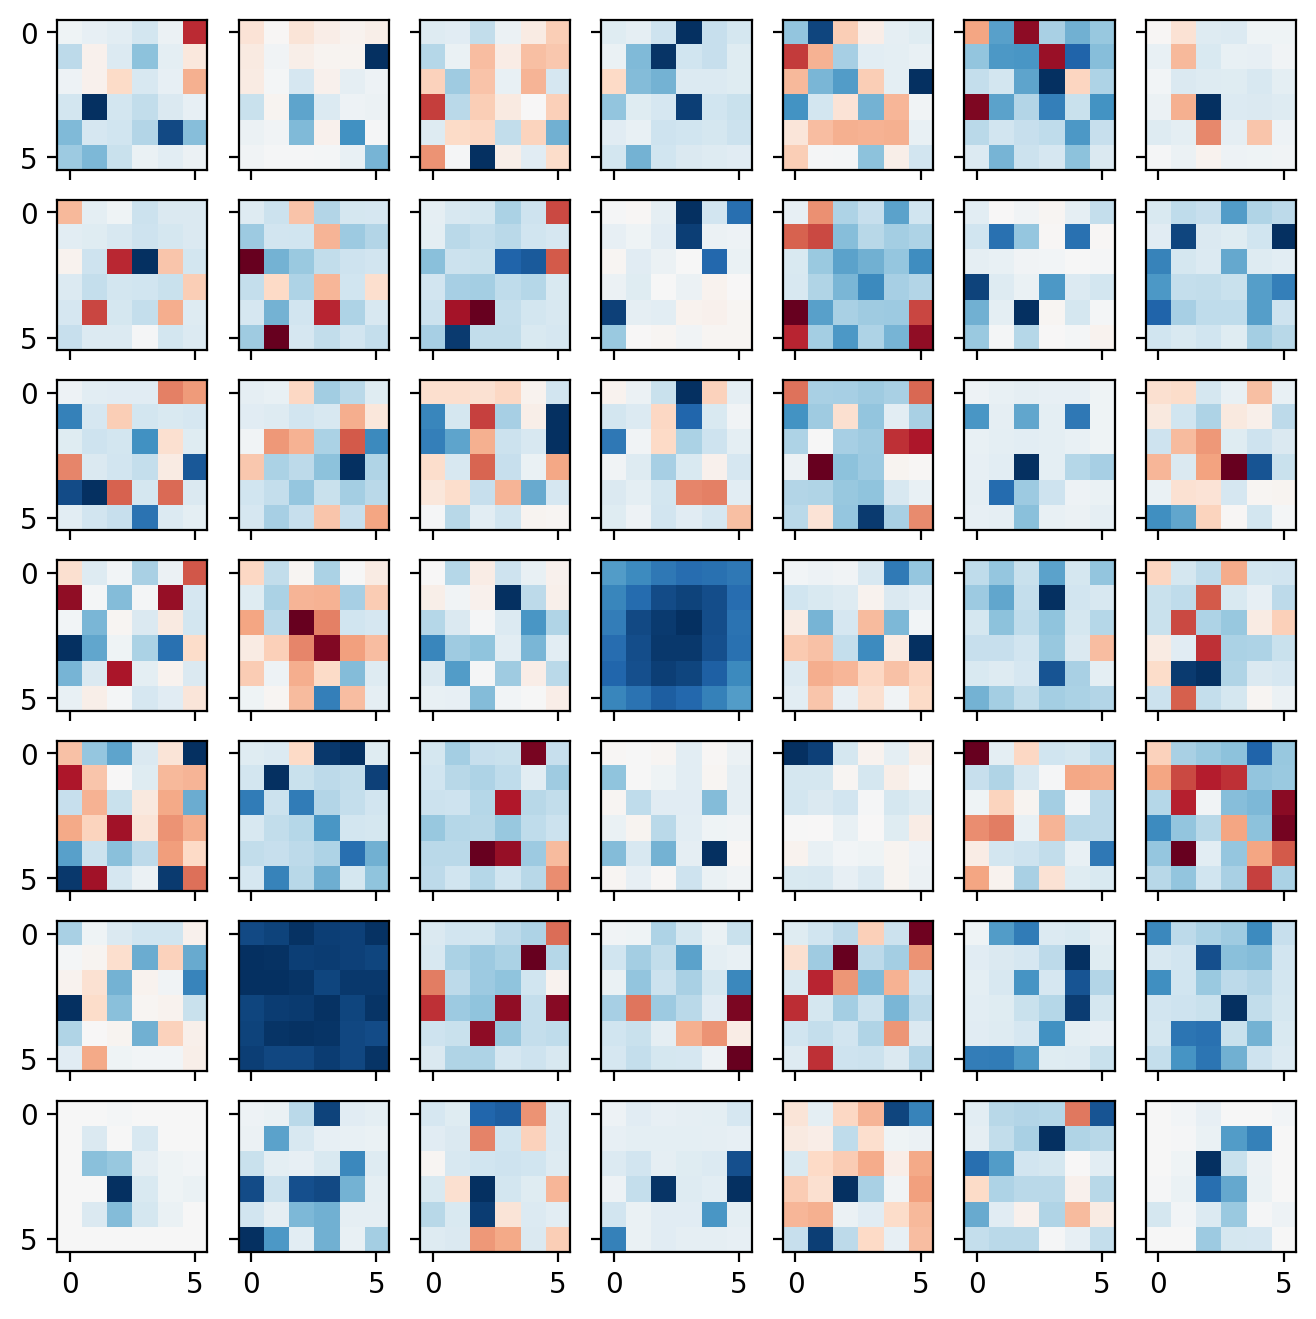

In [39]:
filters = model.encoder.weight.detach().numpy()  # type: ignore

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8, 8))
for i in range(7):
    for j in range(7):
        crt_filter = filters[i * 7 + j, 0]
        crt_max = np.max(np.abs(crt_filter))
        ax[i][j].imshow(crt_filter, vmin=-crt_max, vmax=crt_max, cmap="RdBu")

In [7]:
train_labels_data = []
train_embedded_data = []

###########################################
# Extract train set values after training #
###########################################
for idx, data in enumerate(tqdm(train_loader, desc="train")):
    images, lbl = data

    outputs = model(images.to(device).type(torch.FloatTensor))
    pooled_outputs = model.pool_output(outputs, k_size=2, stri=2)

    if train_embedded_data == []:
        train_embedded_data = pooled_outputs.detach().cpu()
        train_labels_data = lbl
    else:
        train_embedded_data = torch.cat(
            (train_embedded_data, pooled_outputs.detach().cpu()), 0
        )
        train_labels_data = torch.cat((train_labels_data, lbl), 0)

test_labels_data = []
test_embedded_data = []

##########################################
# Extract test set values after training #
##########################################
for idx, data in enumerate(tqdm(test_loader, desc="test")):
    images, lbl = data

    outputs = model(images.to(device).type(torch.FloatTensor))
    pooled_outputs = model.pool_output(outputs, k_size=2, stri=2)

    if test_embedded_data == []:
        test_embedded_data = pooled_outputs.detach().cpu()
        test_labels_data = lbl
    else:
        test_embedded_data = torch.cat(
            (test_embedded_data, pooled_outputs.detach().cpu()), 0
        )
        test_labels_data = torch.cat((test_labels_data, lbl), 0)

train:   0%|          | 0/600 [00:00<?, ?it/s]

test:   0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
n_train = len(train_embedded_data)
resh_train_embedded_data = train_embedded_data.reshape(n_train, -1)

rng = np.random.default_rng(42)
indices = rng.integers(0, n_train, size=n_train)
data = resh_train_embedded_data.numpy()[indices, :]
target = train_labels_data[indices].numpy()

classifier = SGDClassifier(
    alpha=0.0001,
    average=False,
    class_weight=None,
    early_stopping=False,
    epsilon=0.1,
    eta0=0.001,
    fit_intercept=True,
    l1_ratio=0.15,
    learning_rate="optimal",
    loss="hinge",
    max_iter=1000,
    n_iter_no_change=5,
    n_jobs=-1,
    penalty="l2",
    power_t=0.5,
    random_state=123,
    shuffle=True,
    tol=0.001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False,
)
classifier.fit(data, target)

train_error = classifier.score(data, target)

n_test = len(test_embedded_data)
resh_test_embedded_data = test_embedded_data.reshape(n_test, -1)
score = classifier.score(resh_test_embedded_data.numpy(), test_labels_data.numpy())

print(f"Accuracy of the network on the 10000 test images: {100 * score:.1f}%.")

Accuracy of the network on the 10000 test images: 98.2%.


## Try the supervised convolutional NSM module

In [9]:
torch.manual_seed(42)
n_epochs = 3

# tau = np.array([1e4, 1e1])
num_labels = len(classes)
# alpha_ = np.logspace(2, -2, 5)
running_loss = []
alpha = 1e-1
tau = 1e-1
tauLabel = 1e0
# for tau_ in tau:
# Train the model
# for tauLabel in alpha_:
model = Supervised_NSM_Conv(
    1, 50, 6, num_labels, etaW=1e-3, etaM=1e-3, tau=tau, tauLabel=tauLabel
)
for epoch in range(n_epochs):
    pbar = tqdm(train_loader, desc=f"epoch {epoch + 1} / {n_epochs}")
    sample = 0
    for idx, data in enumerate(pbar):
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        one_hot_labels = F.one_hot(labels, num_classes=num_labels)
        repeat_labels = torch.tile(
            alpha * one_hot_labels[:, :, None, None], images.shape[2:4]
        )
        # repeat_labels = einops.repeat(
        #     alpha * one_hot_labels,
        #     "m n -> m n k l",
        #     k=images.shape[2],
        #     l=images.shape[3],
        # ).float()

        # forward pass
        # XXX why are the labels multiplied by 10 only here??
        outputs = model(images, 10 * repeat_labels)
        # loss estimation
        loss = model.loss_NSM_conv(
            outputs, images.to(device), repeat_labels, print_=False
        )
        # backward pass
        model.train(outputs, images, repeat_labels)
        if device.type == "cuda":
            torch.cuda.empty_cache()

        running_loss.append(loss.item())

        pbar.set_postfix(
            {"sample": sample, "loss": running_loss[-1] / batch_size}, refresh=False
        )
        sample += len(images)

epoch 1 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 2 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

epoch 3 / 3:   0%|          | 0/600 [00:00<?, ?it/s]

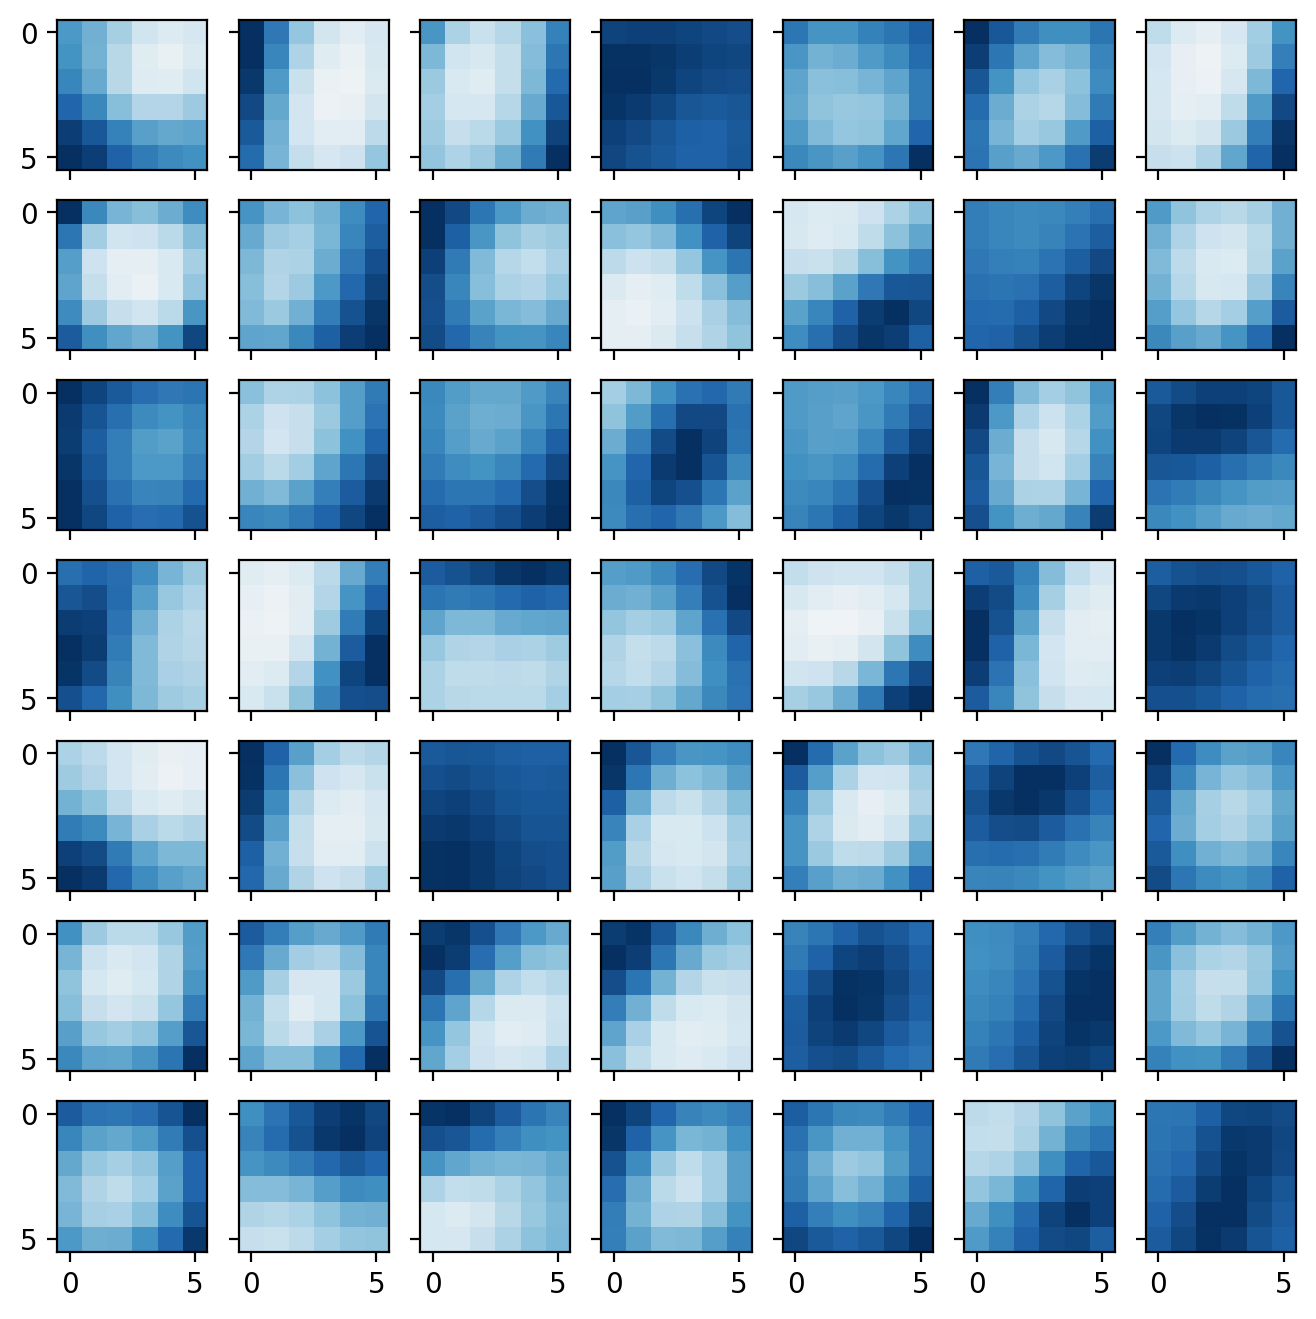

In [10]:
filters = model.encoder.weight.detach().numpy()

fig, ax = plt.subplots(7, 7, sharex=True, sharey=True, figsize=(8, 8))
for i in range(7):
    for j in range(7):
        crt_filter = filters[i * 7 + j, 0]
        crt_max = np.max(np.abs(crt_filter))
        ax[i][j].imshow(crt_filter, vmin=-crt_max, vmax=crt_max, cmap="RdBu")

In [11]:
train_labels_data = []
train_embedded_data = []

###########################################
# Extract train set values after training #
###########################################
for idx, data in enumerate(tqdm(train_loader, desc="train")):
    images, labels = data

    mock_labels = torch.zeros(len(labels), num_labels, *images.shape[2:4])
    # one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_labels)
    # repeat_labels = einops.repeat(
    #     0 * one_hot_labels, "m n -> m n k l", k=images.shape[2], l=images.shape[3]
    # ).float()

    # forward pass
    outputs = model(images.to(device), mock_labels.to(device))
    pooled_outputs = model.pool_output(outputs, k_size=2, stri=2)

    if train_embedded_data == []:
        train_embedded_data = pooled_outputs.detach().cpu()
        train_labels_data = labels
    else:
        train_embedded_data = torch.cat(
            (train_embedded_data, pooled_outputs.detach().cpu()), 0
        )
        train_labels_data = torch.cat((train_labels_data, labels), 0)

test_labels_data = []
test_embedded_data = []

##########################################
# Extract test set values after training #
##########################################
for idx, data in enumerate(tqdm(test_loader, desc="test")):
    images, labels = data

    mock_labels = torch.zeros(len(labels), num_labels, *images.shape[2:4])
    # one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_labels)
    # repeat_labels = einops.repeat(
    #     0 * one_hot_labels, "m n -> m n k l", k=images.shape[2], l=images.shape[3]
    # ).float()

    # forward pass
    outputs = model(images.to(device), mock_labels.to(device))
    pooled_outputs = model.pool_output(outputs, k_size=2, stri=2)

    if test_embedded_data == []:
        test_embedded_data = pooled_outputs.detach().cpu()
        test_labels_data = labels
    else:
        test_embedded_data = torch.cat(
            (test_embedded_data, pooled_outputs.detach().cpu()), 0
        )
        test_labels_data = torch.cat((test_labels_data, labels), 0)

train:   0%|          | 0/600 [00:00<?, ?it/s]

test:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
n_train = len(train_embedded_data)
resh_train_embedded_data = train_embedded_data.reshape(n_train, -1)

rng = np.random.default_rng(42)
indices = rng.integers(0, n_train, size=n_train)
data = resh_train_embedded_data.numpy()[indices, :]
target = train_labels_data[indices]

classifier = SGDClassifier(
    alpha=0.0001,
    average=False,
    class_weight=None,
    early_stopping=False,
    epsilon=0.1,
    eta0=0.001,
    fit_intercept=True,
    l1_ratio=0.15,
    learning_rate="optimal",
    loss="hinge",
    max_iter=1000,
    n_iter_no_change=5,
    n_jobs=-1,
    penalty="l2",
    power_t=0.5,
    random_state=123,
    shuffle=True,
    tol=0.001,
    validation_fraction=0.1,
    verbose=0,
    warm_start=False,
)
classifier.fit(data, target)

train_error = classifier.score(data, target)

n_test = len(test_embedded_data)
resh_test_embedded_data = test_embedded_data.reshape(n_test, -1)
data_test = resh_test_embedded_data.numpy()
target_test = test_labels_data.numpy()
score = classifier.score(data_test, target_test)

print(f"Accuracy of the network on the 10000 test images: {100 * score:.1f}%.")

Accuracy of the network on the 10000 test images: 97.9%.


In [13]:
# alpha = 1e0
# tau = 1e-1
# tauLabel = 1e0
# Accuracy = 23%

# alpha = 1e-1
# tau = 1e0
# tauLabel = 1e1
# Accuracy = 34%

# alpha = 1e-1
# tau = 1e-1
# tauLabel = 1e0
# Accuracy = 33%

# alpha = 0
# tau = 1e-1
# tauLabel = 1e0
# Accuracy = 34%